# Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [6]:
rail_df = pd.read_csv('alltransit-railridership_cleaned.csv', encoding='utf-8')
rail_df.head()

,Agency,Mode/Type of Service Status,UZA Name,Mode,TOS,Year,UPT,VRM,Organization Type,city,...,Avg Fares Per Trip FY,rank,score,tci,jobs,trips/week,routes,transit shed (mi2),%transit,population
0,King County,Inactive,"Seattle--Tacoma, WA",LR,DO,2002,357935,39630,"City, County or Local Government Unit or Depar...",Seattle,...,0.553756,95,8.3,4.9,403896,4783,19,38,0.214,734731
1,Tri-County Metropolitan Transportation Distric...,Active,"Portland, OR--WA",LR,DO,2002,25665600,3198863,Independent Public Agency or Authority of Tran...,Portland,...,0.898112,127,8.1,2.6,218492,3517,10,44,0.109,641885
2,City of Seattle,Active,"Seattle--Tacoma, WA",MG,PT,2002,2048787,220116,"City, County or Local Government Unit or Depar...",Seattle,...,2.910862,95,8.3,4.9,403896,4783,19,38,0.214,734731
3,Central Puget Sound Regional Transit Authority,Active,"Seattle--Tacoma, WA",CR,PT,2002,672495,286613,Independent Public Agency or Authority of Tran...,Seattle,...,2.850825,95,8.3,4.9,403896,4783,19,38,0.214,734731
4,Massachusetts Bay Transportation Authority,Inactive,"Boston, MA--NH",CR,DO,2002,40569600,22747143,Independent Public Agency or Authority of Tran...,Boston,...,3.169348,13,9.1,7.1,732061,5983,14,68,0.306,665942


In [ ]:
rail_df.columns

Index(['Agency', 'Mode/Type of Service Status', 'UZA Name', 'Mode', 'TOS',
       'Year', 'UPT', 'VRM', 'Organization Type', 'city', 'state',
       'UZA SQ Miles', 'UZA Population', 'Service Area Population',
       'Service Area SQ Miles', 'Avg Trip Length FY', 'Fares FY',
       'Operating Expenses FY', 'Avg Cost Per Trip FY',
       'Avg Fares Per Trip FY', 'rank', 'score', 'tci', 'jobs', 'trips/week',
       'routes', 'transit shed (mi2)', '%transit', 'population'],
      dtype='object')

### Which transit agencies have the highest ridership? What’s the agency with the highest ridership per state? Which cities has the highest ridership per capita?

In [ ]:
# Transit Agencies with the highest ridership
# UPT: Total # of persons who've boarded a railway

# .apply(lambda x: f'{x:,}') | Add comma formatting

q1_mostRidership = rail_df.groupby(['Agency','city'])['UPT'].sum().sort_values(ascending=False).astype('Int64').apply(lambda x: f'{x:,}').to_frame().reset_index()
q1_mostRidership.head(10)

,Agency,city,UPT
0,Massachusetts Bay Transportation Authority,Boston,"5,302,250,865"
1,Washington Metropolitan Area Transit Authority,Washington,"5,249,483,547"
2,Chicago Transit Authority,Chicago,"4,299,462,519"
3,Southeastern Pennsylvania Transportation Autho...,Philadelphia,"3,164,852,196"
4,San Francisco Bay Area Rapid Transit District,Oakland,"2,315,514,732"
5,MTA Long Island Rail Road,New York,"2,143,060,547"
6,New Jersey Transit Corporation,Newark,"2,119,341,935"
7,Los Angeles County Metropolitan Transportation...,Los Angeles,"1,980,659,087"
8,"Metro-North Commuter Railroad Company, dba: MT...",New York,"1,699,575,885"
9,Port Authority Trans-Hudson Corporation,New York,"1,656,219,248"


In [ ]:
# Agencys with highest ridership of their state
q1_ridershipByState = rail_df.groupby(['state','Agency'])['UPT'].sum().sort_values(ascending=False).astype('Int64').to_frame()

one_state, dropIndices = set(), []
for rail in q1_ridershipByState.index:
    if rail[0] not in one_state:
        one_state.add(rail[0])
    else:
        dropIndices += [rail]
q1_ridershipByState = q1_ridershipByState.drop(dropIndices).reset_index()

print(f'States with rails: {len(q1_ridershipByState)}')
q1_ridershipByState.head()

States with rails: 34


,state,Agency,UPT
0,MA,Massachusetts Bay Transportation Authority,5302250865
1,DC,Washington Metropolitan Area Transit Authority,5249483547
2,IL,Chicago Transit Authority,4299462519
3,PA,Southeastern Pennsylvania Transportation Autho...,3164852196
4,CA,San Francisco Bay Area Rapid Transit District,2315514732


In [ ]:
# Ridership per capita
q1_ridershipByCapita = rail_df[['city','state','trips/week','population']].drop_duplicates()
q1_ridershipByCapita['Yearly Ridership per Capita'] = q1_ridershipByCapita['trips/week']*52 / q1_ridershipByCapita['population']
q1_ridershipByCapita = q1_ridershipByCapita.sort_values('Yearly Ridership per Capita', ascending=False)
q1_ridershipByCapita.head()

,city,state,trips/week,population,Yearly Ridership per Capita
7,Newington,CT,2451,30458,4.184516
18,Johnstown,PA,1171,18422,3.305396
9,Camden,NJ,2469,71799,1.788159
756,Morgantown,WV,1132,33409,1.761920
60,San Carlos,CA,837,28846,1.508840


### How has ridership changed over time since 2002 across the US as a whole and by city? Will cities that have seen an increase in ridership have a higher AllTransit Score

In [ ]:
# Overall US Ridership
q2_ridershipOvertime = rail_df.groupby('Year')['UPT'].sum().astype('int64')

# q2_ridershipOvertime.head()
q2_ridershipOvertime[2020]

786496517

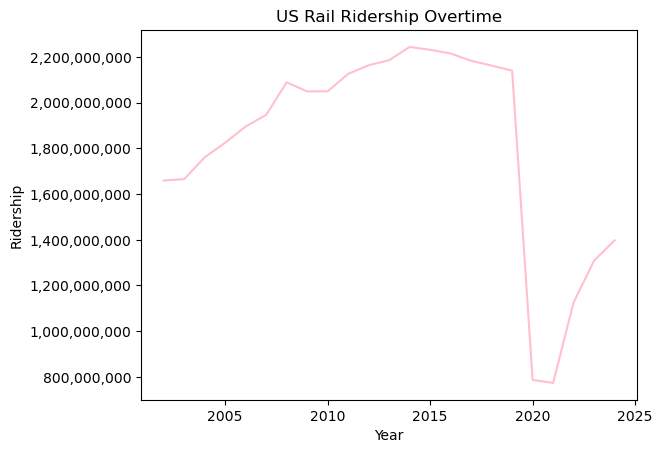

In [ ]:
plt.plot(q2_ridershipOvertime.index, q2_ridershipOvertime, color='pink')
plt.title('US Rail Ridership Overtime')
plt.xlabel('Year')
plt.ylabel('Ridership')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

In [ ]:
# Ridership per State
q2_ridershipOvertimebyState = rail_df.groupby(['Year','state'])['UPT'].sum().astype('int64').reset_index()

print(f'States: {len(q2_ridershipOvertimebyState['state'].unique())}')
q2_ridershipOvertimebyState.head()

States: 34


,Year,state,UPT
0,2002,CA,250618450
1,2002,CO,10429571
2,2002,CT,340626
3,2002,DC,244548262
4,2002,FL,21950973


In [ ]:
# Pruning states by total ridreship to 10 states, 34 is too many to display
q2_statefilter = set(rail_df.groupby('state')['UPT'].sum().sort_values(ascending=False).reset_index().head(10)['state'])

q2_statefilter

{'CA', 'DC', 'GA', 'IL', 'MA', 'NJ', 'NY', 'OR', 'PA', 'TX'}

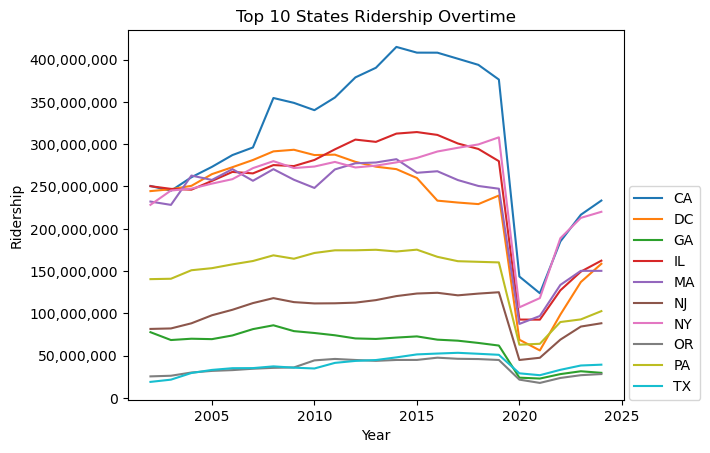

In [ ]:
for state in tuple(q2_ridershipOvertimebyState['state'].unique()):
    if state in q2_statefilter:
        dataframe = q2_ridershipOvertimebyState[q2_ridershipOvertimebyState['state'] == state]
        plt.plot(dataframe['Year'], dataframe['UPT'], label=state)
plt.title('Top 10 States Ridership Overtime')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.xlabel('Year')
plt.ylabel('Ridership')
plt.legend(loc=(1.01,0))
plt.show()

In [ ]:
q2_ridershipOvertime = q2_ridershipOvertime.reset_index()

q2_ridershipOvertime.head(3)

,index,Year,UPT
0,0,2002,1659534986
1,1,2003,1665829263
2,2,2004,1761216642


c:\Users\jchan\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


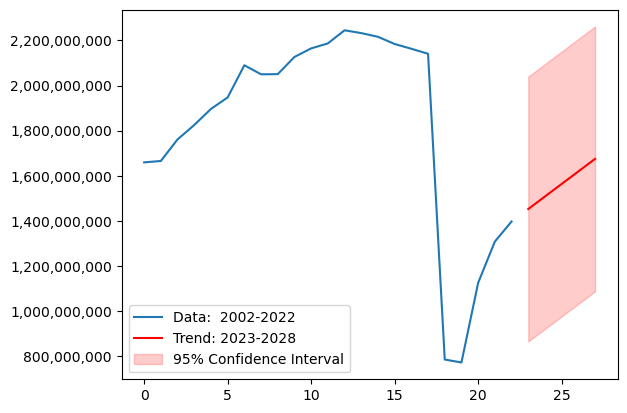

In [ ]:
# US UPT Forecast Data Prep
forecast_horizon = 5
values = q2_ridershipOvertime['UPT']

model = ExponentialSmoothing(values, trend='add').fit(optimized=True)
forecast = model.forecast(forecast_horizon)
forecast_variance = np.var(model.fittedvalues - values)
std_error = np.sqrt(forecast_variance)
ci_upper = forecast + 1.96*std_error
ci_lower = forecast - 1.96*std_error

plt.plot(values, label='Data:  2002-2022')
plt.plot(forecast, color='red', label='Trend: 2023-2028')
plt.fill_between(
    forecast.index,
    ci_lower,
    ci_upper,
    color='red',
    alpha=0.2,
    label='95% Confidence Interval',
)
plt.legend(loc='lower left')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

### How does access to jobs impact transit ridership? Do cities with more jobs accessible to public transit have higher ridership?  

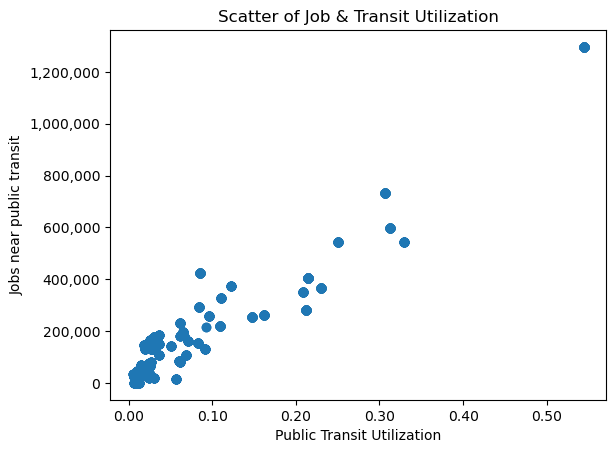

In [ ]:
plt.scatter(
    rail_df['%transit'],
    rail_df['jobs']
)
plt.xlabel('Public Transit Utilization')
plt.ylabel('Jobs near public transit')
plt.title(f'Scatter of Job & Transit Utilization')
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.gca().xaxis.set_major_formatter('{:,.2f}'.format)
plt.show()

### Which mode of rail transportation is most popular? Does it vary by population of a city? Do big cities have more variety in modes of rail transportation?  

Top 5: Light Rail, Commuter Rail, Heavy Rail, Street Car, Monorail

In [ ]:
# Most popular mode of transportation
q5_popularRail = rail_df.groupby('Mode')['Mode'].count().sort_values(ascending=False)

q5_popularRail.head()

Mode
LR    579
CR    551
HR    303
SR    254
MG    116
Name: Mode, dtype: int64

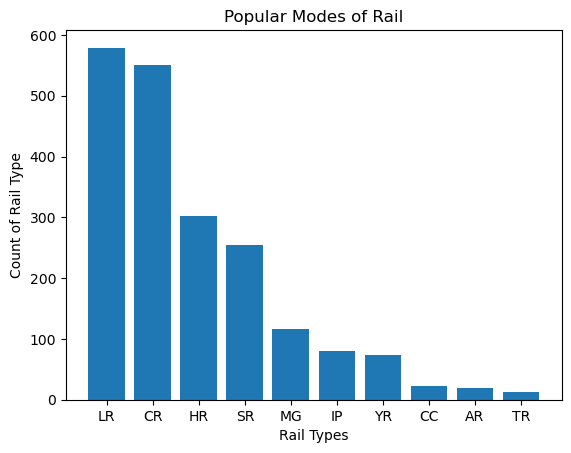

In [ ]:
plt.bar(q5_popularRail.index, q5_popularRail)
plt.title('Popular Modes of Rail')
plt.xlabel('Rail Types')
plt.ylabel('Count of Rail Type')
plt.show()

In [ ]:
# Do big cities have more variety in modes of transportation
# Part A: Modes of Transport
q5_cityModesVariety = rail_df[['city','population']].drop_duplicates().drop_duplicates(subset=['city'], keep='first')

modesList = []
for city in tuple(q5_cityModesVariety['city'].unique()):
    modesList.append(rail_df[rail_df['city'] == city]['Mode'].unique())

q5_cityModesVariety['Modes of Transportation'] = [ ', '.join(modes) for modes in modesList ]
q5_cityModesVariety['Total Modes'] = [ len(modes) for modes in modesList ] 

q5_cityModesVariety = q5_cityModesVariety.sort_values(by='Total Modes', ascending=False)

q5_cityModesVariety.head()

,city,population,Modes of Transportation,Total Modes
1,Portland,641885,"LR, CR, SR, YR, TR",5
0,Seattle,734731,"LR, MG, CR, SR",4
19,Philadelphia,1593208,"CR, HR, LR, SR",4
49,Dallas,1330798,"CR, LR, SR",3
54,Oakland,437832,"HR, MG, YR",3


In [ ]:
# Part B: City Classification
# Source for classes: https://www.oecd.org/en/data/indicators/urban-population-by-city-size.html

bins = [5000,50000,200000,500000,1500000,np.inf]
labels = ['Town','Small City','City','Metropolis','Large Metropolis']

q5_cityModesVariety['City Class'] = pd.cut(
    q5_cityModesVariety['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')

q5_cityModesVariety.head()

,city,population,Modes of Transportation,Total Modes,City Class
1,Portland,641885,"LR, CR, SR, YR, TR",5,Metropolis
0,Seattle,734731,"LR, MG, CR, SR",4,Metropolis
19,Philadelphia,1593208,"CR, HR, LR, SR",4,Large Metropolis
49,Dallas,1330798,"CR, LR, SR",3,Metropolis
54,Oakland,437832,"HR, MG, YR",3,City


In [ ]:
# Part C: Average modes per classification

q5_cityModesVarietyAverage =  q5_cityModesVariety.groupby('City Class', observed=False)['Total Modes'].mean().sort_values(ascending=False)

display(q5_cityModesVarietyAverage)

City Class
Large Metropolis    2.333333
Metropolis          1.956522
City                1.812500
Small City          1.545455
Town                1.000000
Name: Total Modes, dtype: float64

In [ ]:
# Most popular modes of transportation by city class size
bins = [5000,50000,200000,500000,1500000,np.inf]
labels = ['Town','Small City','City','Metropolis','Large Metropolis']

q5_popularModes = rail_df.copy()
q5_popularModes['City Class'] = pd.cut(
    q5_popularModes['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')


In [ ]:
q5_popularModesByClass = q5_popularModes.groupby(['City Class','Mode'], observed=True)['Mode'].count().sort_values(ascending=False)

one_class, dropIndices = set(), []
for cityClass in q5_popularModesByClass.index:
    if cityClass[0] not in one_class:
        one_class.add(cityClass[0])
    else:
        dropIndices += [cityClass]
q5_popularModesByClass = q5_popularModesByClass.drop(dropIndices)

display(q5_popularModesByClass)

City Class        Mode
Metropolis        LR      266
City              LR      201
Large Metropolis  CR      120
Small City        CR      100
Town              CR       99
Name: Mode, dtype: int64

### How does fare price impact ridership? Does higher average cost per trip lead to higher average fare per trip and vice versa? Does population or service area impact fare price?  

In [ ]:
# Filter the data to only show results for the year 2024
rail_2024 = rail_df[rail_df['Year']==2024].reset_index()
rail_2024 = rail_2024.rename(columns={'Avg Fares Per Trip FY': 'Avg_Fares_Per_Trip_FY', 'Avg Cost Per Trip FY': 'Avg_Cost_Per_Trip_FY'})

In [ ]:
# Descriptive statistics for average fares per trip
print("Statistics for Avg_Fares_Per_Trip_FY")
print("-"*50)
print(f'count: {rail_2024['Avg_Fares_Per_Trip_FY'].count()}')
print(f'mean: ${rail_2024['Avg_Fares_Per_Trip_FY'].mean():.2f}')
print(f'min: ${rail_2024['Avg_Fares_Per_Trip_FY'].min():.2f}')
print(f"25%: ${rail_2024['Avg_Fares_Per_Trip_FY'].quantile(0.25):.2f}")
print(f'median: ${rail_2024['Avg_Fares_Per_Trip_FY'].median():.2f}')
print(f"75%: ${rail_2024['Avg_Fares_Per_Trip_FY'].quantile(0.75):.2f}")
print(f'max: ${rail_2024['Avg_Fares_Per_Trip_FY'].max():.2f}')
print(f'std: {rail_2024['Avg_Fares_Per_Trip_FY'].std()}')

Statistics for Avg_Fares_Per_Trip_FY
--------------------------------------------------
count: 109
mean: $3.89
min: $0.00
25%: $0.41
median: $0.99
75%: $2.85
max: $160.25
std: 15.82665561950268


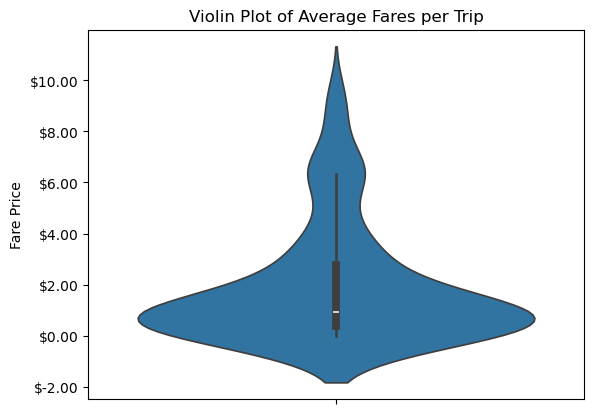

In [ ]:
# Create a histogram for 'Avg_Fares_Per_Trip_FY' filtering out for outliers
rail_no_outlier = rail_2024[rail_2024['Avg_Fares_Per_Trip_FY'] < 10]

# Create a violin plot
sns.violinplot(x=None, y="Avg_Fares_Per_Trip_FY", data=rail_no_outlier)  # set x to 'None' for no grouping
plt.title("Violin Plot of Average Fares per Trip")
plt.ylabel("Fare Price")
plt.gca().yaxis.set_major_formatter('${:.2f}'.format)
plt.show()

#### Fare price and ridership

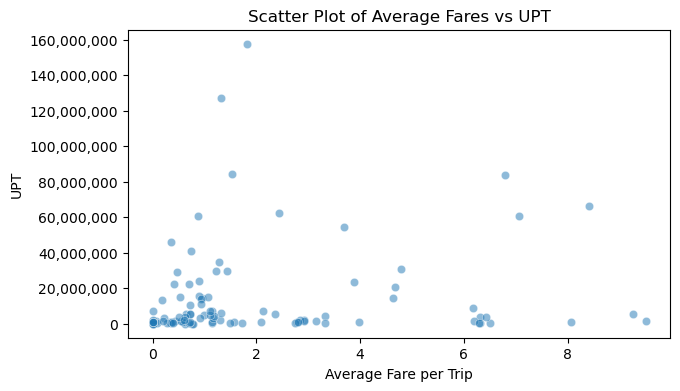

In [ ]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs UPT (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="UPT", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs UPT")
plt.xlabel("Average Fare per Trip")
plt.ylabel("UPT")
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)

plt.show()

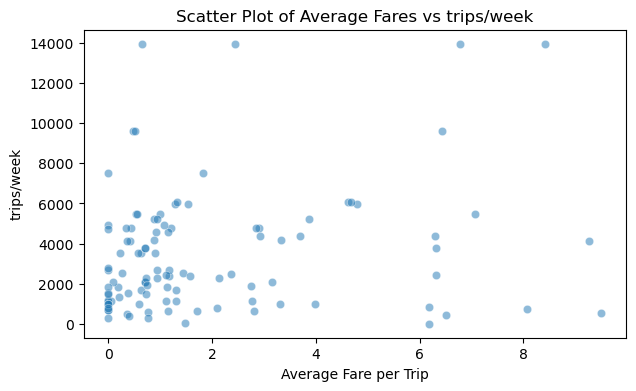

In [ ]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs trips/week (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="trips/week", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs trips/week")
plt.xlabel("Average Fare per Trip")
plt.ylabel("trips/week")

plt.show()

#### Cost per trip and fare price

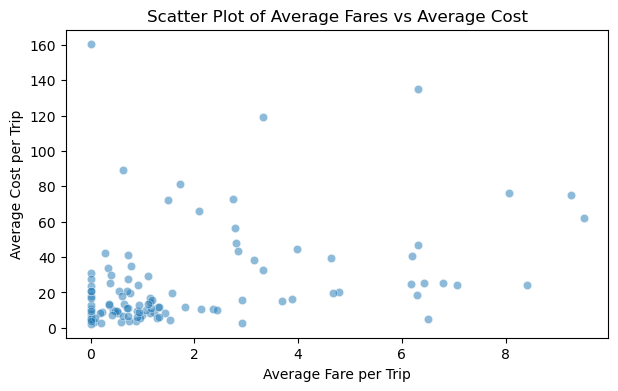

In [ ]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs Avg_Cost_Per_Trip_FY (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="Avg_Cost_Per_Trip_FY", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs Average Cost")
plt.xlabel("Average Fare per Trip")
plt.ylabel("Average Cost per Trip")

plt.show()

#### Does population impact fare price?

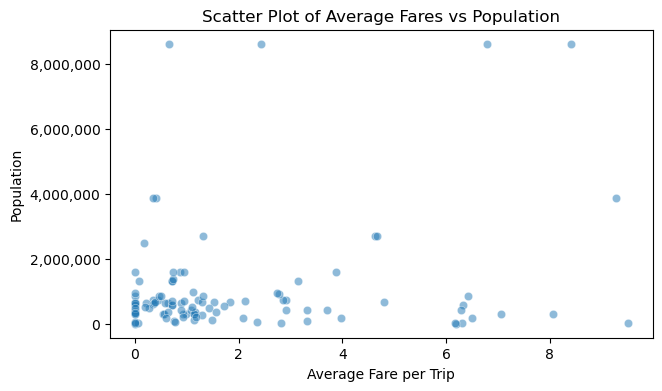

In [ ]:
# create a scatter plot for Average_Fares_Per_Trip_FY (x) vs population (y)
plt.figure(figsize=(7, 4))
sns.scatterplot(x="Avg_Fares_Per_Trip_FY", y="population", data=rail_no_outlier, alpha=0.5) 
plt.title("Scatter Plot of Average Fares vs Population")
plt.xlabel("Average Fare per Trip")
plt.ylabel("Population")
plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

In [ ]:
# Turn population into a categorical variable by binning it based on population
bins = [5000,50000,200000,500000,1500000,np.inf]
labels = ['Town','Small City','City','Metropolis','Large Metropolis']

rail_2024['City_Class'] = pd.cut(
    rail_2024['population'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
).astype('category')

In [ ]:
# fit the ANOVA model
fit = ols("Avg_Fares_Per_Trip_FY ~ City_Class", data=rail_2024).fit()

# display the ANOVA table
anova_table = sm.stats.anova_lm(fit, typ=2)  # Type 2 ANOVA
print(anova_table)

# extract the p-value using iloc
p_value = anova_table["PR(>F)"].iloc[0]
print(f"P-value: {p_value:.8f}")

# interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H0: The average fare price are significantly different across different population sizes.")
else:
    print("Fail to reject H0: No significant difference in average fare price across different population sizes.")

                  sum_sq     df       F    PR(>F)
City_Class    750.900701    4.0  0.7423  0.565291
Residual    26301.266333  104.0     NaN       NaN
P-value: 0.56529089
Fail to reject H0: No significant difference in average fare price across different population sizes.


C:\Users\staro\AppData\Local\Temp\ipykernel_28624\1937240031.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_class = rail_2024.groupby("City_Class").agg({"Avg_Fares_Per_Trip_FY": "mean"})


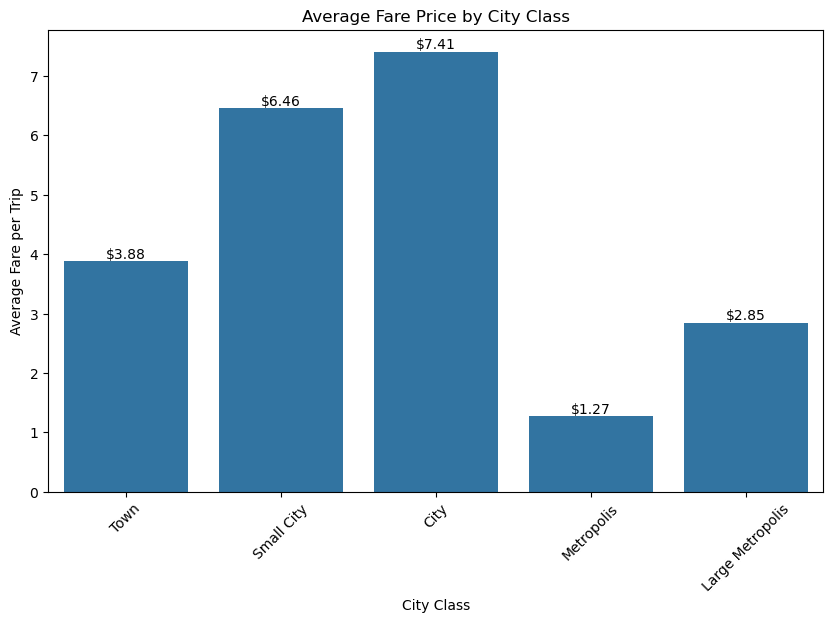

In [ ]:
city_class = rail_2024.groupby("City_Class").agg({"Avg_Fares_Per_Trip_FY": "mean"})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="City_Class", y="Avg_Fares_Per_Trip_FY", data=city_class)

for container in ax.containers:
    for bar in container:
        height = bar.get_height() 
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f"${(height):,.2f}",  
            ha='center', va='bottom', fontsize=10, color='black')

plt.title("Average Fare Price by City Class")
plt.xlabel("City Class")
plt.ylabel("Average Fare per Trip")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

plt.show()

#### Does service area impact fare price?

In [ ]:
# Will work on this later

### Which factors can be used to predict how much ridership a city will have in the future? 

In [ ]:
# Filter data to only use 2024 data because some variables (i.e., population, rank, & fares) are only for 2024
rail_2024 = rail_df[rail_df['Year']==2024].reset_index().copy()

# Filter a dataframe to only incldue the variables we want
rail_2024_filter = rail_2024[['Mode','TOS','Organization Type','UPT', 'VRM','Avg Cost Per Trip FY', 'Avg Fares Per Trip FY', 'score','jobs','trips/week', 'routes','transit shed (mi2)','%transit', 'population']]

# Create dummy variables for our categorical variables
dummies = pd.get_dummies(rail_2024_filter[['Mode','TOS','Organization Type']])

# Concatenate the original DataFrame with the new dummy DataFrame and drop the old columns
rail_2024_filter = pd.concat([rail_2024_filter, dummies], axis=1)
columns_to_drop = ['Mode','TOS','Organization Type']
rail_2024_filter = rail_2024_filter.drop(columns=columns_to_drop)

# Choose which variables we want to use to predict our y variable (UPT).
X = rail_2024_filter.drop('UPT', axis=1).values
y = rail_2024_filter['UPT']

# Split the data using a 80/20 training/testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Create a linear regression model to predict ridership (UPT)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Get predictions from the model
y_pred = lin_reg.predict(X_test)
print(y_pred)

[ -250831.00732667 26151657.909561    1724731.08651233 -3809866.38628678
  1669759.49571    -3653166.20203432 15480184.92057804    88879.15084946
 10389375.61870331 28906622.57813446 13168750.56841458  2503083.34756321
  -336307.97321799   297672.16142218 70265747.8496662   3165711.40109963
 -8586295.55347762  1376687.46622558 -1838673.59400269  5738150.86642795
 10990099.90363029   -84728.3029427 ]


In [ ]:
# Get the R-squared for the model
print(f'R-squared score: {lin_reg.score(X_test, y_test)}')

# Get the intercept
print(f'Intercept: {lin_reg.intercept_}')

# Get the coefficients
print(f'Coefficients:\n {lin_reg.coef_}')

R-squared score: 0.5486020212205438
Intercept: -2397072.293190535
Coefficients:
 [ 1.24780909e+00  1.99143956e+03 -6.56628822e+03 -8.53728731e+05
 -3.48344833e+01  3.40656520e+03  2.30200616e+02  5.14897939e+04
  8.08554135e+06  2.01547989e+00  3.27220736e+06 -5.39150715e+06
 -4.92130068e+06  7.94349349e+06 -1.96324237e+06  6.39895540e+06
 -1.01235462e+06  3.18819695e+05 -9.88906152e+05 -3.65616497e+06
 -7.28545463e+05  7.28545463e+05  1.92637035e+06  5.80491200e+06
 -4.69111233e+05  2.96287153e+06  2.63363947e+05 -1.61554671e+07
  5.66706049e+06]


We got a R-squared score of .549 for our model, which means our model is not doing a good job of predicting UPT using our current variables. We can experiment using different variables to see if we can get a better model.

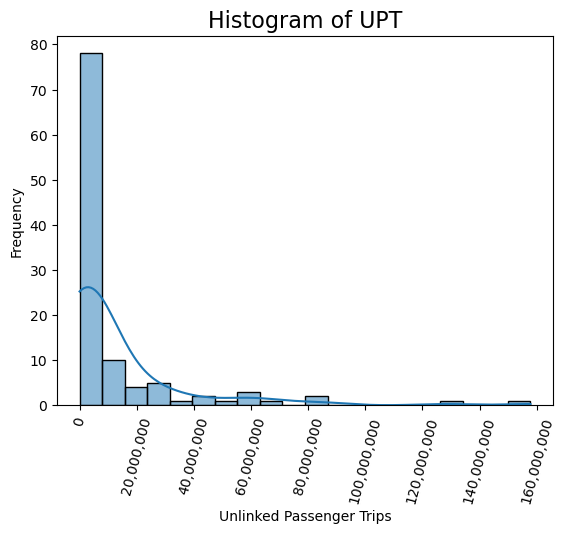

In [ ]:
sns.histplot(rail_2024['UPT'], bins=20, kde=True)
plt.title("Histogram of UPT", fontsize=16)
plt.xlabel("Unlinked Passenger Trips")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter('{:,.0f}'.format)
plt.xticks(rotation=75)
plt.show()

### How do average fares and average cost compare to a rail system’s perceived quality.  In other words, does a rail’s quality correlate with expense and price? 